<a href="https://colab.research.google.com/github/Joh-Ishimwe/Database-Design_Assignment/blob/master/Create_a_Script_to_Fetch_Data_for_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

data = pd.read_csv("laptop_prices.csv")

# Selecting relevant columns

features = ["Company", "Product", "TypeName", "Inches", "Weight", "OS", "Price_euros"]
df = data[features].copy()

# Defining "expensive" (1) and "cheap" (0) based on median price

median_price = df["Price_euros"].median()
df["Label"] = np.where(df["Price_euros"] >= median_price, 1, 0)

# Droping Price_euros from features since it’s the target basis

X = df.drop(columns=["Price_euros", "Label"])
y = df["Label"]

# Converting categorical columns to numerical using LabelEncoder

le_company = LabelEncoder()
le_product = LabelEncoder()
le_typename = LabelEncoder()
le_os = LabelEncoder()

X["Company"] = le_company.fit_transform(X["Company"])
X["Product"] = le_product.fit_transform(X["Product"])
X["TypeName"] = le_typename.fit_transform(X["TypeName"])
X["OS"] = le_os.fit_transform(X["OS"])



if X["Weight"].dtype == "object":
    X["Weight"] = X["Weight"].str.replace("kg", "").astype(float)
else:
    X["Weight"] = X["Weight"].astype(float)

X["Inches"] = X["Inches"].astype(float)

# Spliting into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

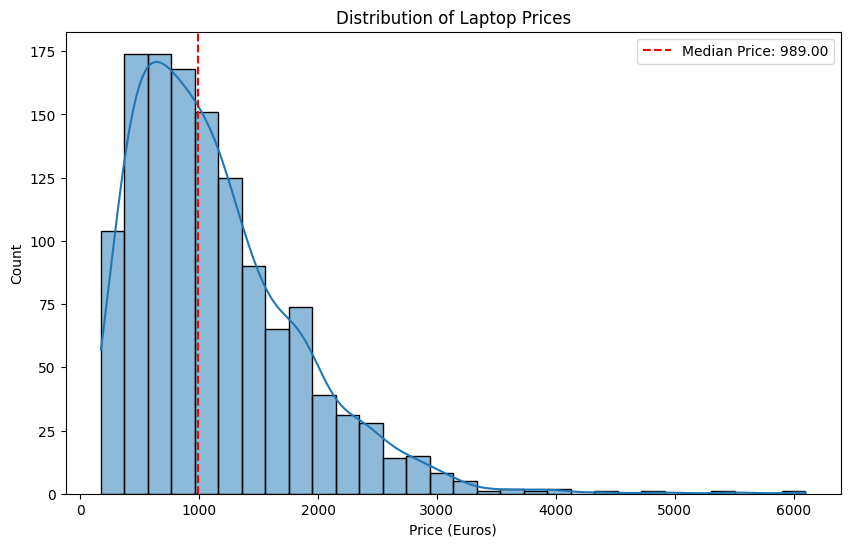

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Price_euros"], bins=30, kde=True)
plt.axvline(median_price, color="red", linestyle="--", label=f"Median Price: {median_price:.2f}")
plt.title("Distribution of Laptop Prices")
plt.xlabel("Price (Euros)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [7]:
# Initializing and training the model

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on test set

y_pred = model.predict(X_test)

# Evaluating the model

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8549019607843137
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       118
           1       0.88      0.84      0.86       137

    accuracy                           0.85       255
   macro avg       0.85      0.86      0.85       255
weighted avg       0.86      0.85      0.86       255



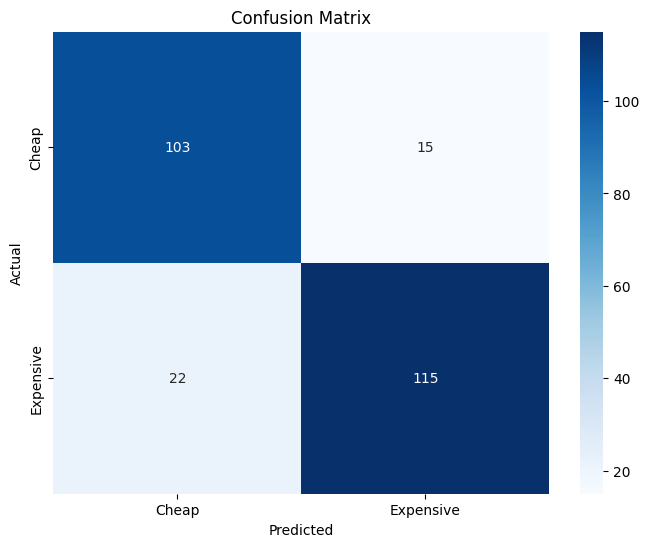

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cheap", "Expensive"], yticklabels=["Cheap", "Expensive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

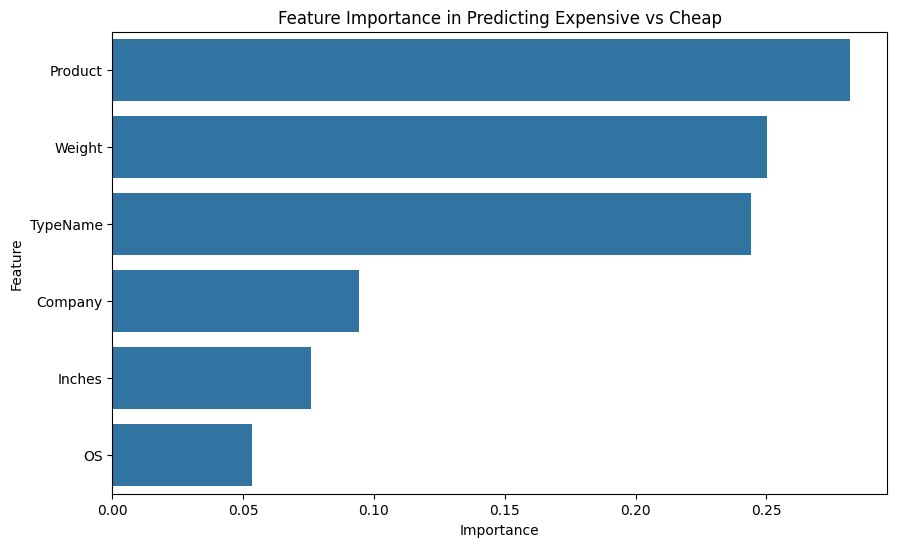

In [9]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance in Predicting Expensive vs Cheap")
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
import joblib


param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}


grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Saving the best model

joblib.dump(best_model, "best_laptop_price_model.pkl")

# Defining and saving the encoders

encoders = {
    "Company": le_company,
    "Product": le_product,
    "TypeName": le_typename,
    "OS": le_os
}

# Save the encoders
joblib.dump(encoders, "label_encoders.pkl")

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best accuracy: 0.8901960784313726


['label_encoders.pkl']

# Script to Fetch Data and Predict

In [11]:
import requests
import pandas as pd
import joblib
import psycopg2
from psycopg2 import Error
import os

# Database connection details

DB_HOST = "dpg-cv8balbqf0us73b6eg40-a.oregon-postgres.render.com"
DB_NAME = "laptopdb"
DB_USER = "laptopdb_user"
DB_PASSWORD = "RgRtnEoW5FdENLIAu7ABvzIutmxpacBu"
DB_PORT = "5432"


# 1. Fetching the latest entry from the API

In [12]:
api_url = "https://database-design-assignment.onrender.com/sql/laptop/1"
def fetch_latest_laptop_data(api_url):
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()
        latest_entry = data
        return latest_entry
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}")
        return None

#  Prepare data for prediction

In [13]:
def safe_transform(encoder, value):
    try:
        return encoder.transform([value])[0]
    except ValueError:

        return 0


def prepare_data_for_prediction(latest_entry, encoders):
    input_data = {
        "Company": latest_entry.get("Company", ""),
        "Product": latest_entry.get("Product", ""),
        "TypeName": latest_entry.get("TypeName", ""),
        "Inches": float(latest_entry.get("Inches", 0)),
        "Weight": float(latest_entry.get("Weight", 0)),
        "OS": latest_entry.get("OS", "")
    }
    input_df = pd.DataFrame([input_data])

    le_company = encoders["Company"]
    le_product = encoders["Product"]
    le_typename = encoders["TypeName"]
    le_os = encoders["OS"]

    input_df["Company"] = safe_transform(le_company, input_df["Company"][0])
    input_df["Product"] = safe_transform(le_product, input_df["Product"][0])
    input_df["TypeName"] = safe_transform(le_typename, input_df["TypeName"][0])
    input_df["OS"] = safe_transform(le_os, input_df["OS"][0])

    return input_data, input_df  # Return raw input_data for logging


In [14]:
# Predicting price
def predict_laptop_price(model, input_df):
    if input_df is None:
        return "Prediction failed due to data issues"
    prediction = model.predict(input_df)[0]
    return "Expensive" if prediction == 1 else "Cheap"

In [15]:
# Check if laptop already exists in database
def check_existing_prediction(input_data):
    try:
        connection = psycopg2.connect(
            host=DB_HOST,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            port=DB_PORT
        )
        cursor = connection.cursor()

        # Query to check if this exact laptop exists
        check_query = """
        SELECT COUNT(*) FROM laptop_predictions
        WHERE company = %s
          AND product = %s
          AND typename = %s
          AND inches = %s
          AND weight = %s
          AND os = %s;
        """
        cursor.execute(check_query, (
            input_data["Company"],
            input_data["Product"],
            input_data["TypeName"],
            input_data["Inches"],
            input_data["Weight"],
            input_data["OS"]
        ))
        count = cursor.fetchone()[0]

        return count > 0  # True if exists, False if not

    except (Exception, Error) as e:
        print(f"Error checking database: {e}")
        return False  # Assume not a duplicate if check fails
    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

# Log prediction to PostgreSQL only if not a duplicate

In [16]:
# Log prediction to PostgreSQL only if not a duplicate)
def log_prediction_to_db(input_data, prediction):
    if check_existing_prediction(input_data):
        print("Prediction already exists in database. Skipping insert.")
        return

    try:
        connection = psycopg2.connect(
            host=DB_HOST,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            port=DB_PORT
        )
        cursor = connection.cursor()

        # Create table if it doesn’t exist (run once)
        create_table_query = """
        CREATE TABLE IF NOT EXISTS laptop_predictions (
            id SERIAL PRIMARY KEY,
            company VARCHAR(50),
            product VARCHAR(100),
            typename VARCHAR(50),
            inches FLOAT,
            weight FLOAT,
            os VARCHAR(50),
            prediction VARCHAR(20),
            prediction_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """
        cursor.execute(create_table_query)

        # Insert prediction
        insert_query = """
        INSERT INTO laptop_predictions (company, product, typename, inches, weight, os, prediction)
        VALUES (%s, %s, %s, %s, %s, %s, %s);
        """
        cursor.execute(insert_query, (
            input_data["Company"],
            input_data["Product"],
            input_data["TypeName"],
            input_data["Inches"],
            input_data["Weight"],
            input_data["OS"],
            prediction
        ))

        connection.commit()
        print("Prediction logged to database successfully.")

    except (Exception, Error) as e:
        print(f"Error logging to database: {e}")
    finally:
        if cursor:
            cursor.close()
        if connection:
            connection.close()

 # Predicting for cheap laptop

In [17]:
# Main execution
if __name__ == "__main__":
    api_url = "https://database-design-assignment.onrender.com/sql/laptop/1"

    model_file = "best_laptop_price_model.pkl"
    encoders_file = "label_encoders.pkl"

    if not os.path.exists(model_file):
        print(f"Error: Model file '{model_file}' not found in {os.getcwd()}")
        exit(1)
    if not os.path.exists(encoders_file):
        print(f"Error: Encoders file '{encoders_file}' not found in {os.getcwd()}")
        exit(1)

    try:
        model = joblib.load(model_file)
        encoders = joblib.load(encoders_file)
        print("Model and encoders loaded successfully.")
    except Exception as e:
        print(f"Error loading files: {e}")
        exit(1)

    latest_entry = fetch_latest_laptop_data(api_url)
    if latest_entry:
        print("Latest Entry:", latest_entry)
        input_data, input_df = prepare_data_for_prediction(latest_entry, encoders)
        result = predict_laptop_price(model, input_df)
        print(f"Prediction: {result}")

        # Log the result to PostgreSQL, skipping duplicates
        log_prediction_to_db(input_data, result)
    else:
        print("Failed to fetch data from API.")

Model and encoders loaded successfully.
Latest Entry: {'LaptopID': 1, 'Product': '250 G6', 'TypeName': 'Notebook', 'Price_euros': 1600.0, 'ScreenID': 1, 'StorageID': 1, 'Company': 'HP', 'Inches': 15.6, 'Weight': 1.86, 'OS': 'No OS', 'CPU_ID': 1, 'GPU_ID': 1}
Prediction: Cheap
Prediction already exists in database. Skipping insert.


#USING THE SAME SCRIPT TO PREDICT FOR EXPENSIVE LAPTOP

In [18]:
# Main execution
if __name__ == "__main__":
    api_url = "https://database-design-assignment.onrender.com/sql/laptop/10"

    model_file = "best_laptop_price_model.pkl"
    encoders_file = "label_encoders.pkl"

    if not os.path.exists(model_file):
        print(f"Error: Model file '{model_file}' not found in {os.getcwd()}")
        exit(1)
    if not os.path.exists(encoders_file):
        print(f"Error: Encoders file '{encoders_file}' not found in {os.getcwd()}")
        exit(1)

    try:
        model = joblib.load(model_file)
        encoders = joblib.load(encoders_file)
        print("Model and encoders loaded successfully.")
    except Exception as e:
        print(f"Error loading files: {e}")
        exit(1)

    latest_entry = fetch_latest_laptop_data(api_url)
    if latest_entry:
        print("Latest Entry:", latest_entry)
        input_data, input_df = prepare_data_for_prediction(latest_entry, encoders)
        result = predict_laptop_price(model, input_df)
        print(f"Prediction: {result}")

        # Log the result to PostgreSQL, skipping duplicates
        log_prediction_to_db(input_data, result)
    else:
        print("Failed to fetch data from API.")

Model and encoders loaded successfully.
Latest Entry: {'LaptopID': 10, 'Product': 'MacBook Pro', 'TypeName': 'Ultrabook', 'Price_euros': 600.0, 'ScreenID': 1, 'StorageID': 1, 'Company': 'Apple', 'Inches': 13.3, 'Weight': 1.37, 'OS': ' macOS', 'CPU_ID': 1, 'GPU_ID': 1}
Prediction: Expensive
Prediction already exists in database. Skipping insert.
